In [1]:
import torch
from config_loader import load_config, get_model_name
from datasets import load_dataset
from plotting import plot_conditioned_examples

config = load_config("VAE")
# Load dataset
train_loader, val_loader, test_loader = load_dataset(config["data_params"])

model_name = get_model_name(config)

x, x_cond, y = next(iter(train_loader))

In [2]:
from lightning_extensions import ExtendedTrainer
from modules import VAEModule

model = VAEModule(config['model_params'], model_name=config['model_name'])

trainer = ExtendedTrainer(project_name="MultiTaskVariationalAutoecnoders_test", **config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which wi

Problem at: /Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py 399 experiment


/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


VAE([128, 256]_2)?dataset=MNIST&batch_size=128&max_epochs=50


/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


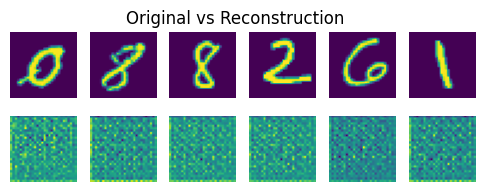

In [2]:
from modules import VAEModule
print(model_name)
model = VAEModule.load_model_checkpoint(model_name = model_name)
model.eval()
from plotting import plot_samples_with_reconstruction
# plot some samples and their reconstruction

plot_samples_with_reconstruction(model, test_loader)